# EDA 002 - Coordinate system study on Voxelmorph vs SITK on MNIST

As was studied on [EDA-001](analyses/EDA_001_ref_coord_system.html), we need to carefully handle reference systems whenever we're working in SITK and Numpy. In our scenario, we displacement fields calculated through Demons algorithm, inside SITK, and displacement fields calculated through Voxelmorph, using numpy.

## Objectives 📋

This notebook aims to:
- Load trained MNIST model on Voxelmorph (refeer to [the VoxelMorph official](http://tutorial.voxelmorph.net/)).
- Get displacement fields from both voxelmorph and SITK.
- Study the coordinate system on both cases.
- Understand the implementation of the [SpatialTransformLayer](https://github.com/voxelmorph/voxelmorph/blob/98d4f368e71683bcb0ee0de9203480153ed1aa9c/voxelmorph/tf/layers.py#L34).

## Imports ⚙️

In [37]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5' # so TF shuts the f up
import SimpleITK as sitk
from tvtk.api import tvtk
import matplotlib.pyplot as plt
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne

## Data&Model loading 📈

In [38]:
def load_data():
    from tensorflow.keras.datasets import mnist
    (x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()
    return x_train_load, y_train_load # just training images

def preprocess_data(images, labels , digit=5):
    pad_amount = ((0, 0), (2,2), (2,2))
    images_digit = images[labels==digit, ...].astype(float) / 255
    images_digit = np.pad(images_digit, pad_amount, 'constant')
    return images_digit

def vxm_data_generator(x_data): # directly from the tutorial
    vol_shape = x_data.shape[1:]
    ndims = len(vol_shape)
    zero_phi = np.zeros([1, *vol_shape, ndims])
    while True:
        idx1 = np.random.randint(0, x_data.shape[0], size=1)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=1)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        outputs = [fixed_images, zero_phi]
        yield (inputs, outputs)

images, labels = load_data()
images = preprocess_data(images, labels)
image_gen = vxm_data_generator(images)
model = vxm.networks.VxmDense.load("model_diff.h5")

## Analysis 👨‍🔬

Two same-digit images will be selected and a registration will be performed with both SITK and VXM.

An example of these fixed and moving digits:

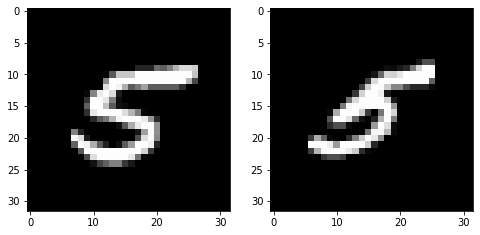

In [83]:
# re-visualize
(fixed, moving), _ = next(image_gen)
fixed_npy, moving_npy = fixed[0, ..., 0], moving[0, ..., 0]
fig, axs = plt.subplots(1, 2, figsize=(8,8))
axs[0].imshow(fixed_npy, cmap="gray")
axs[1].imshow(moving_npy, cmap="gray")
plt.show()


### Registration
Now, we register them with both methodologies, and see how the moved images and displacement fields are in each of them.

There are a few catchs here:
- VXM predicts the $F\to M$ tranform, thus that's why we pass `(fixed, moving)`.
- SITK predicts the $M\to F$ transform, so we pass `(moving_sitk, fixed_sitk)`.


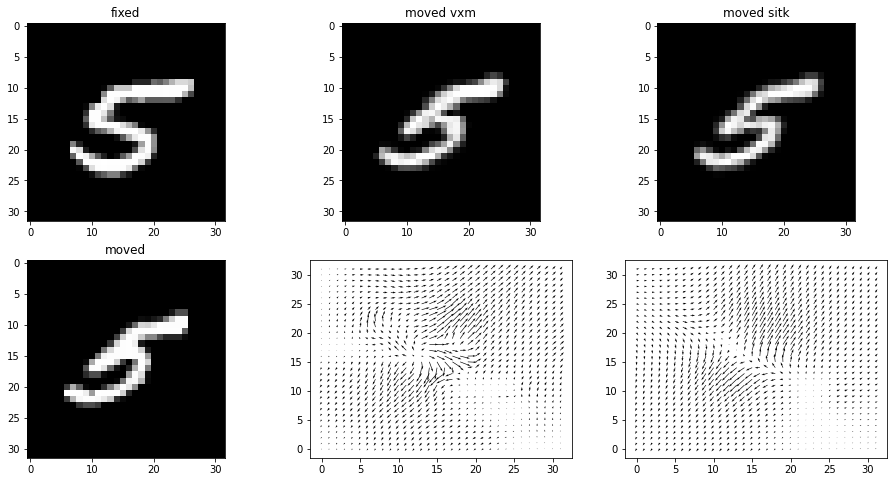

In [89]:
# Registration using VXM (well... it reads easier)
moved_vxm, df_vxm = model.predict((fixed, moving))

# Generation of SITK images, registration and transform
fixed_sitk  = sitk.GetImageFromArray(fixed_npy)
moving_sitk = sitk.GetImageFromArray(moving_npy)

demons_filter = sitk.DiffeomorphicDemonsRegistrationFilter()
demons_filter.SetNumberOfIterations(200)
df_sitk = demons_filter.Execute(moving_sitk, fixed_sitk)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed_sitk)
transform = sitk.DisplacementFieldTransform(sitk.Cast(df_sitk, sitk.sitkVectorFloat64))
resampler.SetTransform(transform)
moved_sitk = resampler.Execute(fixed_sitk)

# Get Numpy representations to plot both SITK and VXM
moved_vxm_npy, df_vxm_npy = moved_vxm[0, ..., 0], df_vxm[0, ...]
moved_sitk_npy = sitk.GetArrayFromImage(moved_sitk)
df_sitk_npy = sitk.GetArrayFromImage(df_sitk)

# Plot images and flows
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0, 0].imshow(fixed_npy, cmap="gray"), axs[0, 0].set_title("fixed")
axs[0, 1].imshow(moved_vxm_npy, cmap="gray"), axs[0,1].set_title("moved vxm")
axs[0, 2].imshow(moved_sitk_npy, cmap="gray"), axs[0,2].set_title("moved sitk")
axs[1, 0].imshow(moving_npy, cmap="gray"), axs[1, 0].set_title("moved")
axs[1, 1].quiver(df_vxm_npy[..., 0], df_vxm_npy[..., 1])
axs[1, 2].quiver(df_sitk_npy[..., 0], df_sitk_npy[..., 1])
plt.show()



### Displacement field comparison

We will now make a comparison between both displacement fields in the numpy representation, after applying the transforms found in [EDA-001](/analyses/EDA_001_ref_coord_system.html). It seems that the transformation obtained from SITK has "the right coordinates", at least when we're getting the array from the image. Thus, if we're grabbing said arraid from the image, it seems we don't have the need to transform any coordinates.

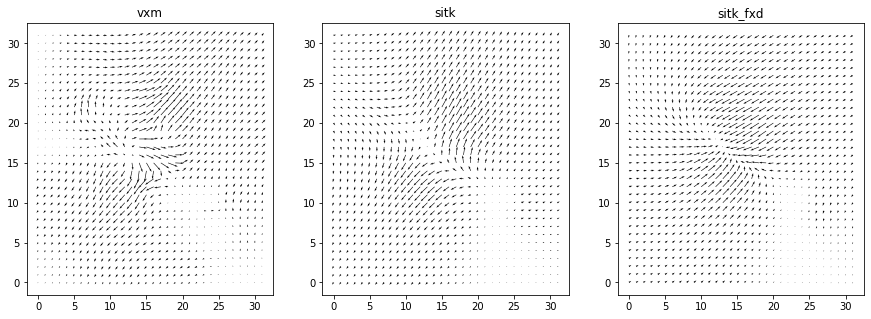

In [113]:
df_sitk_npy_warped = np.zeros_like(df_sitk_npy)
df_sitk_npy_warped[..., 0] = -df_sitk_npy[..., 1] 
df_sitk_npy_warped[..., 1] = -df_sitk_npy[..., 0] 


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].quiver(df_vxm_npy[..., 0], df_vxm_npy[..., 1])
axs[1].quiver(df_sitk_npy[..., 0], df_sitk_npy[..., 1])
axs[2].quiver(df_sitk_npy_warped[..., 0], df_sitk_npy_warped[..., 1])
for idx, title in enumerate(["vxm", "sitk", "sitk_fxd"]):
    axs[idx].set_title(title)
plt.show()


### Cross-use of methodologies

Now we want to study what happens if we grab the SITK transform and try to use it in VXM, and viceversa. I will use the coordinate swap we found in [EDA-001](analyses/EDA_001_ref_coord_system.html).

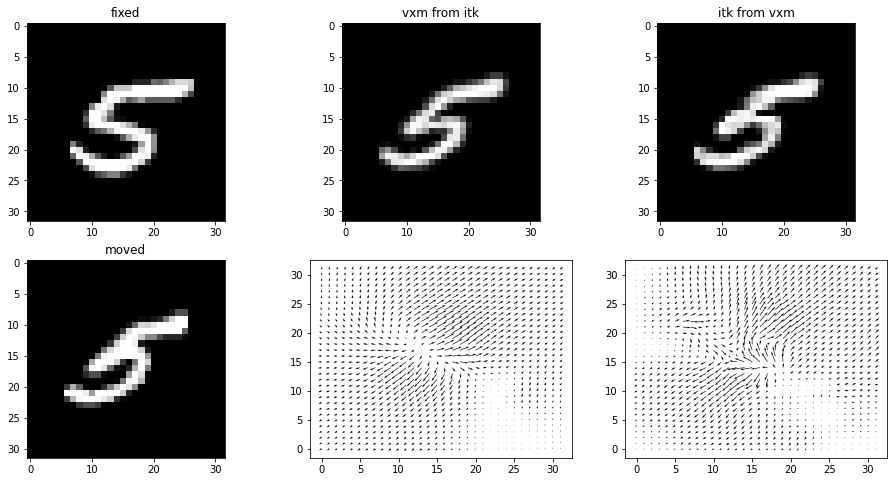

In [114]:
# Change coordinates
df_sitk_npy_swapped = np.zeros_like(df_sitk_npy)
df_sitk_npy_swapped[..., 0] = df_sitk_npy[..., 1]
df_sitk_npy_swapped[..., 1] = df_sitk_npy[..., 0]

df_vxm_npy_swapped = np.zeros_like(df_vxm_npy)
df_vxm_npy_swapped[..., 0] = df_vxm_npy[..., 1]
df_vxm_npy_swapped[..., 1] = df_vxm_npy[..., 0]

# Get new displacement fields
vxm_from_sitk_df = df_sitk_npy_swapped[np.newaxis, ...]
sitk_from_vxm_df = sitk.GetImageFromArray(df_vxm_npy_swapped, isVector=True)

# Transform images
moved_vxm_from_sitk = model.get_layer("transformer")((fixed, vxm_from_sitk_df))

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed_sitk)
transform = sitk.DisplacementFieldTransform(
    sitk.Cast(sitk_from_vxm_df, sitk.sitkVectorFloat64)
)
resampler.SetTransform(transform)
moved_sitk_from_vxm = resampler.Execute(fixed_sitk)

# To numpy, then plot
df_vxm_from_sitk_npy = vxm_from_sitk_df[0, ...] # tautological?
df_sitk_from_vxm_npy = sitk.GetArrayFromImage(sitk_from_vxm_df)
mvd_vxm_from_sitk_npy = moved_vxm_from_sitk[0, ..., 0]
mvd_sitk_from_vxm_npy = sitk.GetArrayFromImage(moved_sitk_from_vxm)

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0, 0].imshow(fixed_npy, cmap="gray"), axs[0,0].set_title("fixed")
axs[0, 1].imshow(mvd_vxm_from_sitk_npy, cmap="gray"), axs[0,1].set_title("vxm from itk")
axs[0, 2].imshow(mvd_sitk_from_vxm_npy, cmap="gray"), axs[0,2].set_title("itk from vxm")
axs[1, 0].imshow(moving_npy, cmap="gray"), axs[1,0].set_title("moved")
axs[1, 1].quiver(df_vxm_from_sitk_npy[..., 0], df_vxm_from_sitk_npy[..., 1])
axs[1, 2].quiver(df_sitk_from_vxm_npy[..., 0], df_sitk_from_vxm_npy[..., 1])
plt.show()


### Comparison between cross methods and direct methods

Finally, we will compare cross results and see diferences.

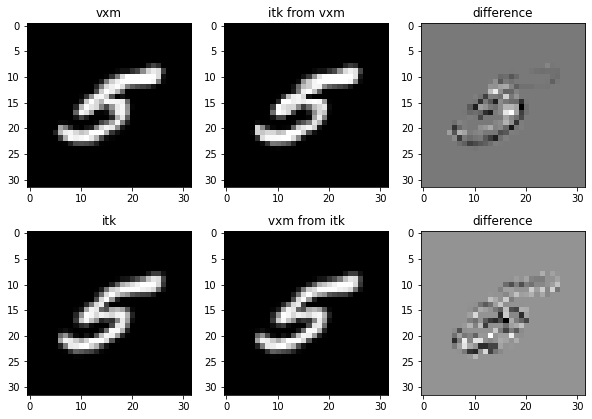

In [121]:
diff_cross_vxm = moved_vxm_npy - mvd_sitk_from_vxm_npy
diff_cross_itk = moved_sitk_npy - mvd_vxm_from_sitk_npy
fig, axs = plt.subplots(2, 3, figsize=(10, 7))
axs[0, 0].imshow(moved_vxm_npy, cmap="gray"), axs[0,0].set_title("vxm")
axs[0, 1].imshow(mvd_sitk_from_vxm_npy, cmap="gray"), axs[0,1].set_title("itk from vxm")
axs[0, 2].imshow(diff_cross_vxm, cmap="gray"), axs[0,2].set_title("difference")
axs[1, 0].imshow(moved_sitk_npy, cmap="gray"), axs[1,0].set_title("itk")
axs[1, 1].imshow(mvd_vxm_from_sitk_npy, cmap="gray"), axs[1,1].set_title("vxm from itk")
axs[1, 2].imshow(diff_cross_itk, cmap="gray"), axs[1,2].set_title("difference")
plt.show()

## Conclusions 💡

An adequate methodology was found to use either SITK or VXM and get the correct displacement field from both of them.

Takeaways:
- SITK calculates $M \to F$ registration, VXM/numpy calculates $F \to M$.
- We must use a $x \to y$ transformation to go from each framework to the other.
- SpatialTransformerLayer is used to transform in VXM, and Resample to transform in SITK.